### Import Packages

In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine, exists
import pymysql

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle


### Cleaning data

#### Connect to database

In [2]:
# Read sensitive information from environment variables
api_key = os.getenv('OPENWEATHERMAP_API_KEY', "5b103a5aa9cd52cd178d63c3c83ad6ec")
db_username = os.getenv('DB_USERNAME', 'admin')
db_password = os.getenv('DB_PASSWORD', 'qwerty123')
db_name = os.getenv('DB_NAME', 'dublinbikes')
db_endpoint = os.getenv('DB_ENDPOINT', 'dublinbikes.ch2g8eocy1o4.eu-west-1.rds.amazonaws.com')
db_port = os.getenv('DB_PORT', '3306')


# Construct the database connection URL, using pymysql as the driver for the MySQL database
database_url = f"mysql+pymysql://{db_username}:{db_password}@{db_endpoint}:{db_port}/{db_name}"

# Attempt to create the database engine and connect
try:
    db = create_engine(database_url)
    conn = db.connect()
    print("Connected to the database successfully.")

except Exception as e:
    print(f"An error occurred: {e}")

Connected to the database successfully.


#### Get data

In [3]:
# withdraw data
query_station = "SELECT * FROM station"
query_availability = "SELECT * FROM availability"
query_weather = "SELECT * FROM weather"

df_station = pd.read_sql_query(query_station, db)
df_availability = pd.read_sql_query(query_availability, db)
df_weather = pd.read_sql_query(query_weather, db)

#### Weather Table

In [4]:
# 1. check data
print(df_weather.head())
print(df_weather.info())
print(df_weather.describe())

# 2. clean data
# only save columns we need
columns_to_keep = ['weather_main', 'weather_description', 'temperature', 'feels_like', 'pressure', 'humidity', 'visibility', 'wind_speed', 'wind_deg', 'clouds_all', 'last_update']
df_weather = df_weather[columns_to_keep]
# delete duplicate rows
df_weather.drop_duplicates(inplace=True)

# Fill in or remove missing values (here, the choice is to remove rows that contain any missing values).
df_weather.dropna(inplace=True)

   number weather_main weather_description  weather_id weather_icon  \
0       1       Clouds       broken clouds         803          04n   
1       2       Clouds    scattered clouds         802          03n   
2       3       Clouds    scattered clouds         802          03n   
3       4       Clouds       broken clouds         803          04n   
4       5       Clouds    scattered clouds         802          03n   

   position_lat  position_long  temperature  feels_like  temp_min  ...  \
0        53.344        -6.2672       279.58      277.69    278.51  ...   
1        53.344        -6.2672       279.39      276.21    278.51  ...   
2        53.344        -6.2672       279.34      276.15    277.58  ...   
3        53.344        -6.2672       279.58      277.69    278.51  ...   
4        53.344        -6.2672       279.34      276.15    277.58  ...   

          last_update  sys_type   sys_id  sys_country         sys_sunrise  \
0 2024-02-27 23:15:21       2.0  2016139           

In [5]:
print(df_weather.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1810 entries, 0 to 1812
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   weather_main         1810 non-null   object        
 1   weather_description  1810 non-null   object        
 2   temperature          1810 non-null   float64       
 3   feels_like           1810 non-null   float64       
 4   pressure             1810 non-null   float64       
 5   humidity             1810 non-null   float64       
 6   visibility           1810 non-null   float64       
 7   wind_speed           1810 non-null   float64       
 8   wind_deg             1810 non-null   float64       
 9   clouds_all           1810 non-null   float64       
 10  last_update          1810 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 169.7+ KB
None


#### Station Table

In [6]:
# 1. check data
print(df_station.head())
print(df_station.info())
print(df_station.describe())

# 2. clean data
# only save columns we need
columns_to_keep_station = ['number', 'name', 'address', 'position_lat', 'position_long', 'bike_stands']
df_station = df_station[columns_to_keep_station]

# delete duplicate rows
df_station.drop_duplicates(inplace=True)

              address  banking  bike_stands  bonus contract_name  \
0       Clarendon Row        0           31      0        dublin   
1  Blessington Street        0           20      0        dublin   
2       Bolton Street        0           20      0        dublin   
3        Greek Street        0           20      0        dublin   
4   Charlemont Street        0           40      0        dublin   

                 name  number  position_lat  position_long  
0       CLARENDON ROW       1     53.340927      -6.262501  
1  BLESSINGTON STREET       2     53.356769      -6.268140  
2       BOLTON STREET       3     53.351182      -6.269859  
3        GREEK STREET       4     53.346874      -6.272976  
4    CHARLEMONT PLACE       5     53.330662      -6.260177  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   address        114 non-null 

In [7]:
print(df_station.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   number         114 non-null    int64  
 1   name           114 non-null    object 
 2   address        114 non-null    object 
 3   position_lat   114 non-null    float64
 4   position_long  114 non-null    float64
 5   bike_stands    114 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 5.5+ KB
None


#### Availibility Table

In [8]:
# 1. check data
print(df_availability.head())
print(df_availability.info())
print(df_availability.describe())

# 2. clean
# Fill in or remove missing values.
# For dynamic data, ensure there is no missing key information, such as available\_bikes. Here, we choose to remove rows that contain any missing values.
df_availability.dropna(inplace=True)

# Remove unnecessary columns
# We decide to keep the station number, the number of available bikes, the number of available slots, and the last update time.
columns_to_keep_availability = ['number', 'available_bikes', 'available_bike_stands', 'last_update']
df_availability = df_availability[columns_to_keep_availability]

df_availability.drop_duplicates(inplace=True)

   id  number  available_bikes  available_bike_stands         last_update  \
0   1      42               29                      1 2024-02-18 05:12:40   
1   2      30                8                     12 2024-02-18 05:10:22   
2   3      54               15                     18 2024-02-18 05:09:23   
3   4     108               15                     20 2024-02-18 05:08:23   
4   5      20                0                     30 2024-02-18 05:10:51   

  status  
0   OPEN  
1   OPEN  
2   OPEN  
3   OPEN  
4   OPEN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728924 entries, 0 to 1728923
Data columns (total 6 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   id                     int64         
 1   number                 int64         
 2   available_bikes        int64         
 3   available_bike_stands  int64         
 4   last_update            datetime64[ns]
 5   status                 object        
dtypes: datetim

In [9]:
print(df_availability.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1064959 entries, 0 to 1728923
Data columns (total 4 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   number                 1064959 non-null  int64         
 1   available_bikes        1064959 non-null  int64         
 2   available_bike_stands  1064959 non-null  int64         
 3   last_update            1064959 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 40.6 MB
None


Make sure we start from the same date

In [10]:
# make sure the format
df_weather['last_update'] = pd.to_datetime(df_weather['last_update'])

# keep the data after 2024-02-28
df_weather_filtered = df_weather[df_weather['last_update'] >= '2024-02-28']


In [11]:
# make sure the format
df_availability['last_update'] = pd.to_datetime(df_availability['last_update'])

# keep the data after 2024-02-28
df_availability_filtered = df_availability[df_availability['last_update'] >= '2024-02-28']


Check again

In [12]:
print(df_availability_filtered.info())
print(df_weather_filtered.info())

<class 'pandas.core.frame.DataFrame'>
Index: 878329 entries, 295841 to 1728923
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   number                 878329 non-null  int64         
 1   available_bikes        878329 non-null  int64         
 2   available_bike_stands  878329 non-null  int64         
 3   last_update            878329 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 33.5 MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1805 entries, 8 to 1812
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   weather_main         1805 non-null   object        
 1   weather_description  1805 non-null   object        
 2   temperature          1805 non-null   float64       
 3   feels_like           1805 non-null   float64       
 4   pressure         

In [13]:
# we only have 117 stations so should keep number between 1 and 117(include)
df_availability_filtered = df_availability_filtered[(df_availability_filtered['number'] >= 1) & (df_availability_filtered['number'] <= 117)]
print(df_availability_filtered.shape)
print(df_availability_filtered.sample(5))  # print 5 rows to check data


(878329, 4)
         number  available_bikes  available_bike_stands         last_update
474395       61                7                     18 2024-03-04 10:59:45
305966        3                3                     17 2024-02-28 07:19:47
512542       21               18                     12 2024-03-05 14:53:31
366607      107               15                     25 2024-03-01 03:46:53
1578906       6                3                     17 2024-04-07 05:58:01


#### Calculated outlier

In [14]:
print("Availability Statistical Summary:")
print(df_availability_filtered[['available_bikes', 'available_bike_stands']].describe())

Availability Statistical Summary:
       available_bikes  available_bike_stands
count    878329.000000          878329.000000
mean         12.003717              19.868928
std           9.893444              11.109064
min           0.000000               0.000000
25%           3.000000              11.000000
50%          10.000000              20.000000
75%          19.000000              29.000000
max          40.000000              40.000000


Availability dataset observations: 
Available bikes (available_bikes): Average is about 12.3, with a standard deviation close to 10, indicating that the number of available bikes varies significantly between sites. The minimum value is 0 (no available bikes), and the maximum value is 40 (possibly the maximum capacity of some sites). Available parking spaces (available_bike_stands): Average is about 19.5, with a standard deviation of about 11.2, similar to the distribution of available bikes, indicating that the availability of parking spaces also varies significantly. The minimum and maximum values are also 0 and 40, consistent with the maximum value of bikes.致。

In [15]:
print("\nWeather Statistical Summary:")
# Update reserved numeric columns
weather_numerical_columns = ['temperature', 'feels_like', 'pressure', 'humidity', 'visibility', 'wind_speed', 'wind_deg', 'clouds_all']
print(df_weather_filtered[weather_numerical_columns].describe())


Weather Statistical Summary:
       temperature   feels_like     pressure     humidity    visibility  \
count  1805.000000  1805.000000  1805.000000  1805.000000   1805.000000   
mean    282.447922   280.264582  1000.455956    82.774515   9216.898615   
std       2.882051     4.094172    12.676727     8.485517   1745.779542   
min     274.240000   268.230000   968.000000    52.000000   1500.000000   
25%     280.490000   277.260000   993.000000    77.000000  10000.000000   
50%     282.020000   279.380000  1000.000000    84.000000  10000.000000   
75%     284.440000   283.690000  1010.000000    90.000000  10000.000000   
max     291.610000   291.310000  1024.000000    98.000000  10000.000000   

        wind_speed     wind_deg   clouds_all  
count  1805.000000  1805.000000  1805.000000  
mean      6.304654   175.534072    64.722438  
std       2.881686    80.725237    19.878148  
min       0.170000     0.000000     0.000000  
25%       4.120000   110.000000    75.000000  
50%       6.

temperature: 
1. The mean temperature is about 282.03K (about 8.88°C), and the standard deviation is about 2.61K, indicating that the temperature is relatively stable during the observation period. The temperature ranges from 274.24K (about 1.09°C) to 288.63K (about 15.48°C). 
2. feels_like: The average feels_like temperature is slightly lower than the actual temperature, which is expected because the feels_like temperature is affected by wind speed and humidity. 
3. pressure: The average pressure is about 999.84 hpa, and the pressure varies from 968 to 1024 hpa, indicating that the pressure change is not very large during the observation period. 
The average humidity was high, about 83.53%, indicating that the weather was humid during the observation period. 
4. visibility: The average visibility is 9165.19 meters, and some data reaches the maximum of 10,000 meters (which may be the upper limit of the data), indicating good visibility most of the time. 
5. Wind speed (wind_speed): The average wind speed is about 5.96 m/s, and the wind speed varies from 0.17 to 14.4 m/s, indicating that the wind speed is sometimes relatively high.对较高。致。

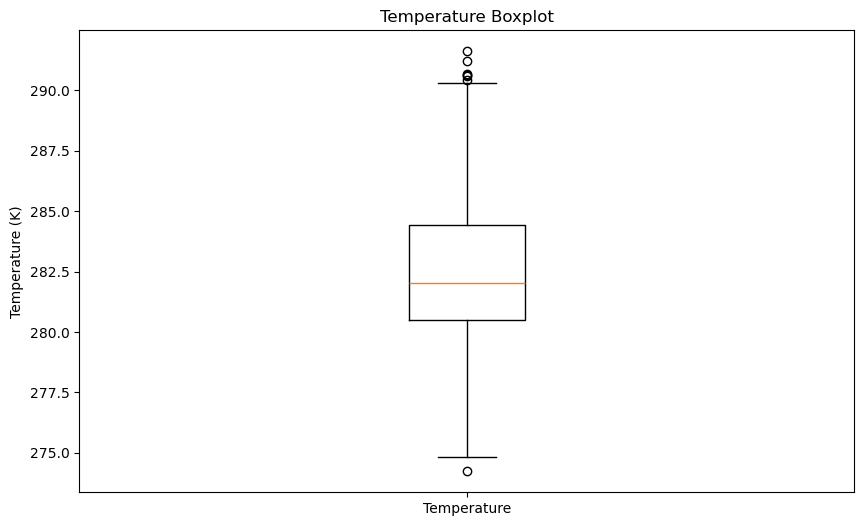

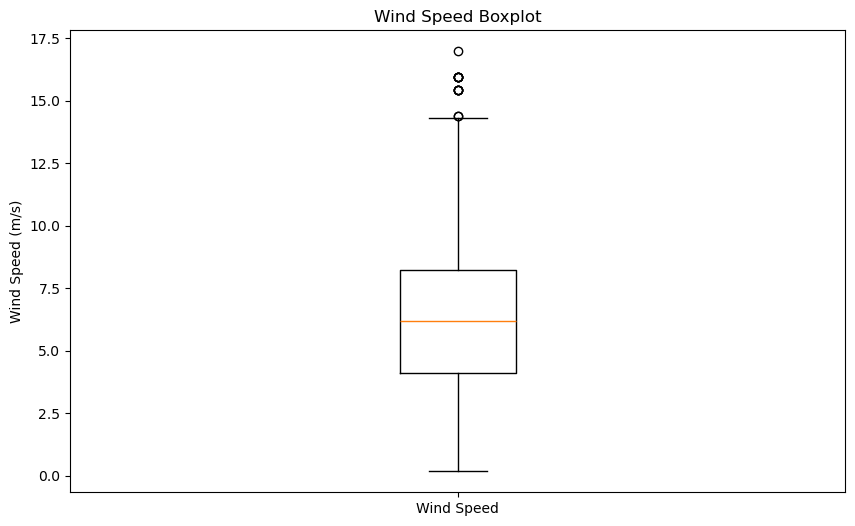

In [16]:
# Box diagram of temperature
plt.figure(figsize=(10, 6))
plt.boxplot(df_weather_filtered['temperature'].dropna())
plt.title('Temperature Boxplot')
plt.ylabel('Temperature (K)')
plt.xticks([1], ['Temperature'])
plt.show()

# Box diagram of windSpeed
plt.figure(figsize=(10, 6))
plt.boxplot(df_weather_filtered['wind_speed'].dropna())
plt.title('Wind Speed Boxplot')
plt.ylabel('Wind Speed (m/s)')
plt.xticks([1], ['Wind Speed'])
plt.show()


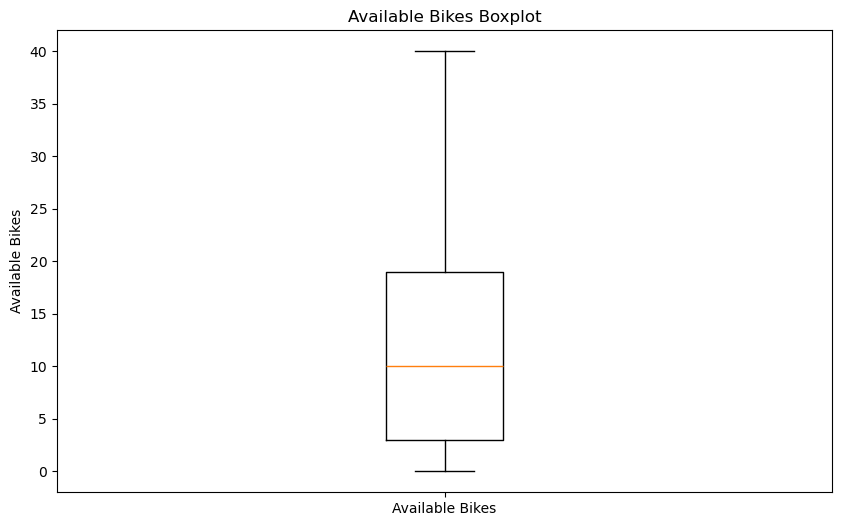

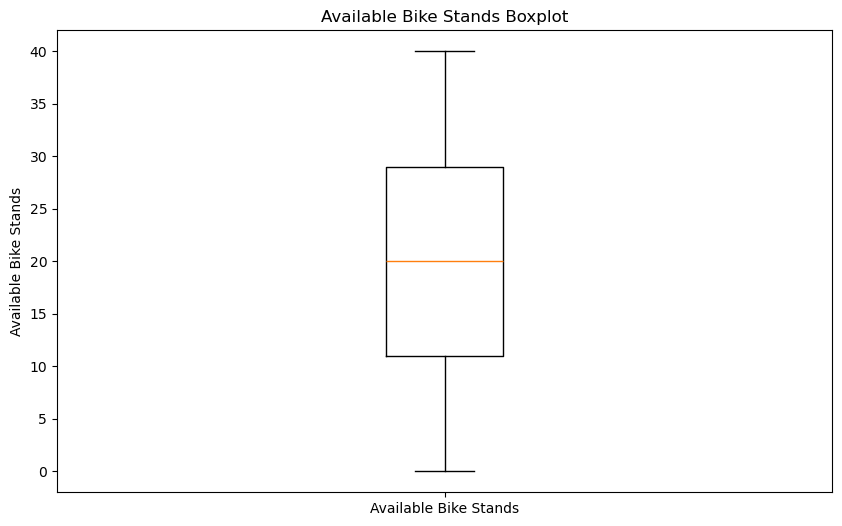

In [17]:
# The box diagram of the bicycle is available
plt.figure(figsize=(10, 6))
plt.boxplot(df_availability_filtered['available_bikes'].dropna())
plt.title('Available Bikes Boxplot')
plt.ylabel('Available Bikes')
plt.xticks([1], ['Available Bikes'])
plt.show()

# Box map of available parking Spaces
plt.figure(figsize=(10, 6))
plt.boxplot(df_availability_filtered['available_bike_stands'].dropna())
plt.title('Available Bike Stands Boxplot')
plt.ylabel('Available Bike Stands')
plt.xticks([1], ['Available Bike Stands'])
plt.show()


All good!!!! 

In order to more accurately match weather conditions, the weather data is temporally interpolated to create a denser time series dataset. Next, the interpolated weather data was combined with the bike availability data by last_update and number (station number). In this way, each bike data point will have a corresponding weather condition.况。

In [18]:
# Defines a list of category type columns
category_columns = ['weather_main', 'weather_description']

# Make sure the 'last_update' column is part of the DataFrame
if 'last_update' not in df_weather_filtered.columns:
    df_weather_filtered = df_weather_filtered.reset_index()

# Convert 'last_update' to the datetime type, where.loc is used to avoid SettingWithCopyWarning
df_weather_filtered.loc[:, 'last_update'] = pd.to_datetime(df_weather_filtered.loc[:, 'last_update'])

# Select numeric columns for interpolation
df_weather_numerical = df_weather_filtered.set_index('last_update')[weather_numerical_columns]
df_weather_interpolated = df_weather_numerical.interpolate(method='time').reset_index()

# Use.ffill() directly for forward fill to avoid FutureWarning
df_weather_filtered.loc[:, category_columns] = df_weather_filtered.loc[:, category_columns].ffill()

# Merge the categorical data back into the interpolated numerical data
df_weather_final = pd.merge(df_weather_interpolated, df_weather_filtered.loc[:, ['last_update'] + category_columns].drop_duplicates(), on='last_update', how='left')

# show the result to check
print(df_weather_final.head())


          last_update  temperature  feels_like  pressure  humidity  \
0 2024-02-28 00:26:21       278.85      276.10    1018.0      80.0   
1 2024-02-28 00:55:00       278.87      276.13    1018.0      80.0   
2 2024-02-28 01:27:46       278.97      276.58    1018.0      80.0   
3 2024-02-28 01:58:16       279.26      276.93    1017.0      80.0   
4 2024-02-28 02:27:23       279.29      276.64    1017.0      80.0   

   visibility  wind_speed  wind_deg  clouds_all weather_main  \
0     10000.0        3.60     210.0        40.0       Clouds   
1     10000.0        3.60     210.0        40.0       Clouds   
2     10000.0        3.09     200.0        40.0       Clouds   
3     10000.0        3.09     200.0        75.0         Rain   
4     10000.0        3.60     210.0        75.0         Rain   

  weather_description  
0    scattered clouds  
1    scattered clouds  
2    scattered clouds  
3          light rain  
4          light rain  


In [19]:
# Sort the two Dataframes by last_update
df_availability_sorted = df_availability_filtered.sort_values('last_update')
df_weather_sorted = df_weather_final.sort_values('last_update')

# Use merge_asof to find the most recent time record to merge
# We use nearest, so that the nearest can be found regardless of whether the timestamp is first or last
df_combined = pd.merge_asof(df_availability_sorted, df_weather_sorted,
                            on='last_update', direction='nearest')

print(df_combined.head())


   number  available_bikes  available_bike_stands         last_update  \
0      13                0                     30 2024-02-28 00:00:00   
1      59                7                     13 2024-02-28 00:00:02   
2     103                8                     32 2024-02-28 00:00:02   
3      73                7                     23 2024-02-28 00:00:06   
4      22               10                     10 2024-02-28 00:00:07   

   temperature  feels_like  pressure  humidity  visibility  wind_speed  \
0       278.85       276.1    1018.0      80.0     10000.0         3.6   
1       278.85       276.1    1018.0      80.0     10000.0         3.6   
2       278.85       276.1    1018.0      80.0     10000.0         3.6   
3       278.85       276.1    1018.0      80.0     10000.0         3.6   
4       278.85       276.1    1018.0      80.0     10000.0         3.6   

   wind_deg  clouds_all weather_main weather_description  
0     210.0        40.0       Clouds    scattered clouds 

In [20]:
# Print 5 random rows of data for verification
print(df_combined.sample(5))

        number  available_bikes  available_bike_stands         last_update  \
507700      72                9                     22 2024-03-24 07:38:41   
572961     103                0                     40 2024-03-27 12:57:05   
407066      39                1                     19 2024-03-19 09:46:15   
301112       4                6                     14 2024-03-14 01:34:22   
442831      53                0                     40 2024-03-21 02:21:51   

        temperature  feels_like  pressure  humidity  visibility  wind_speed  \
507700       278.87      274.89    1014.0      89.0     10000.0        6.17   
572961       280.32      276.39     970.0      74.0     10000.0        7.20   
407066       284.49      283.85    1010.0      83.0     10000.0        5.66   
301112       281.44      279.26    1001.0      93.0      4000.0        3.60   
442831       280.68      277.59    1023.0      82.0     10000.0        5.14   

        wind_deg  clouds_all weather_main           weat

In [21]:
print(df_combined.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878329 entries, 0 to 878328
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   number                 878329 non-null  int64         
 1   available_bikes        878329 non-null  int64         
 2   available_bike_stands  878329 non-null  int64         
 3   last_update            878329 non-null  datetime64[ns]
 4   temperature            878329 non-null  float64       
 5   feels_like             878329 non-null  float64       
 6   pressure               878329 non-null  float64       
 7   humidity               878329 non-null  float64       
 8   visibility             878329 non-null  float64       
 9   wind_speed             878329 non-null  float64       
 10  wind_deg               878329 non-null  float64       
 11  clouds_all             878329 non-null  float64       
 12  weather_main           878329 non-null  obje

### EDA

E:\jupyter\envs\comp30830\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\jupyter\envs\comp30830\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


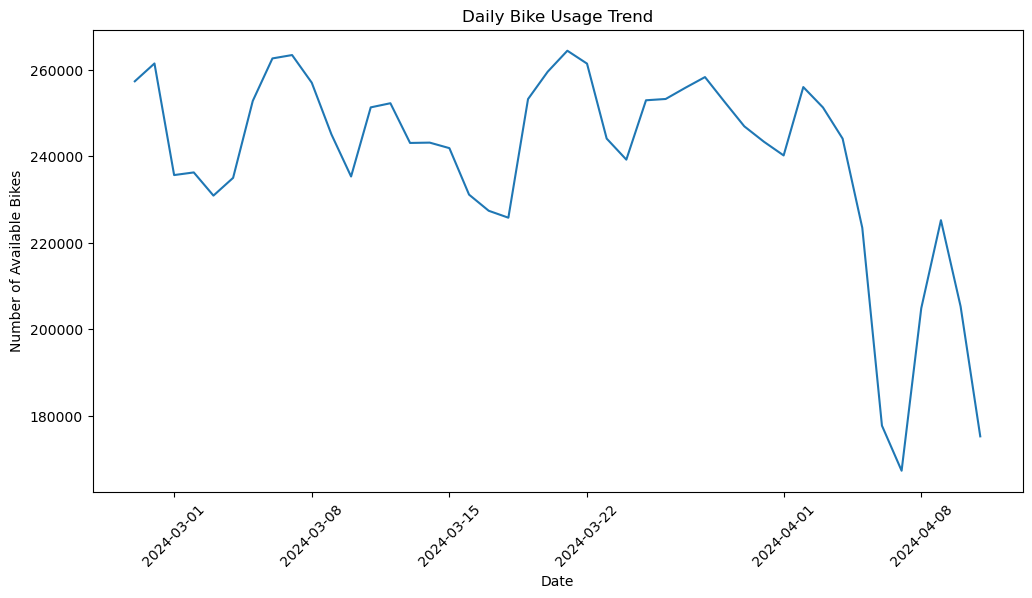

In [22]:
# Chart the trend of bicycle usage by day
df_combined['date'] = df_combined['last_update'].dt.date
daily_bikes = df_combined.groupby('date')['available_bikes'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='available_bikes', data=daily_bikes)
plt.title('Daily Bike Usage Trend')
plt.xlabel('Date')
plt.ylabel('Number of Available Bikes')
plt.xticks(rotation=45)
plt.show()

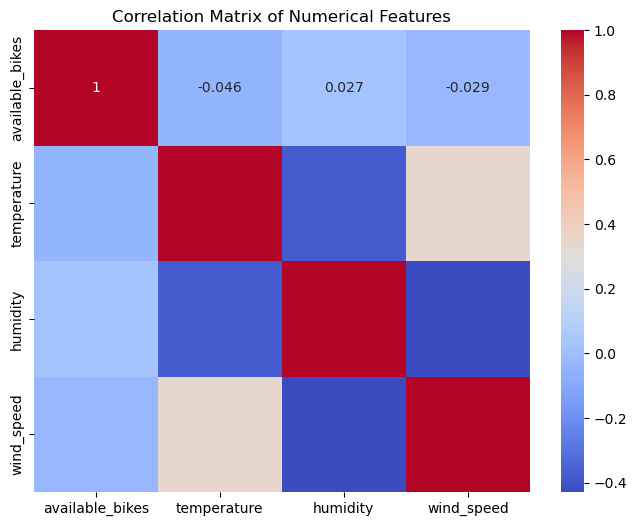

In [23]:
# Calculate correlations between numerical variables
correlation_matrix = df_combined[['available_bikes', 'temperature', 'humidity', 'wind_speed']].corr()

# Draw a correlation heat map
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()


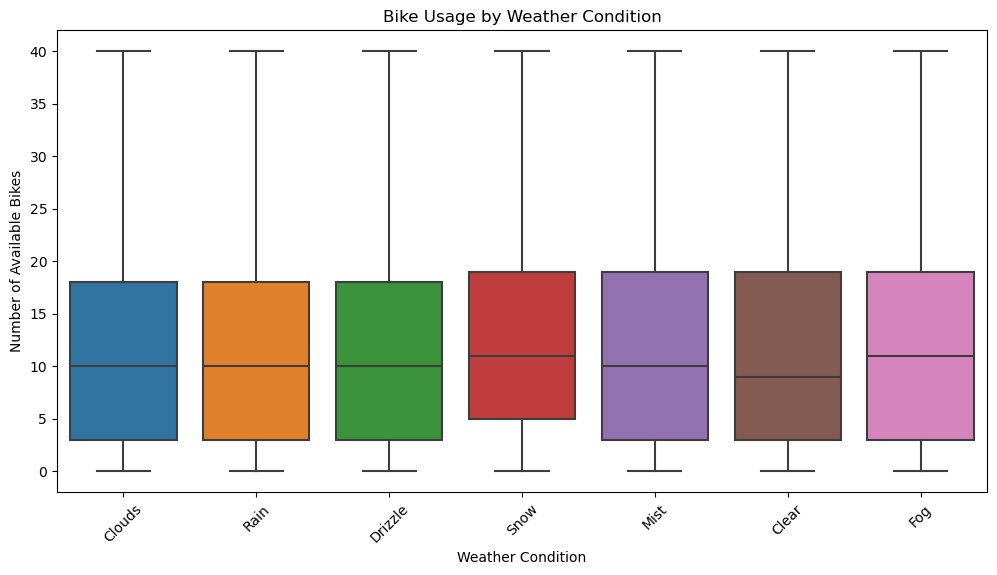

In [24]:
# Analyze bicycle usage in different weather conditions
plt.figure(figsize=(12, 6))
sns.boxplot(x='weather_main', y='available_bikes', data=df_combined)
plt.title('Bike Usage by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Number of Available Bikes')
plt.xticks(rotation=45)
plt.show()


Temperature and bike usage

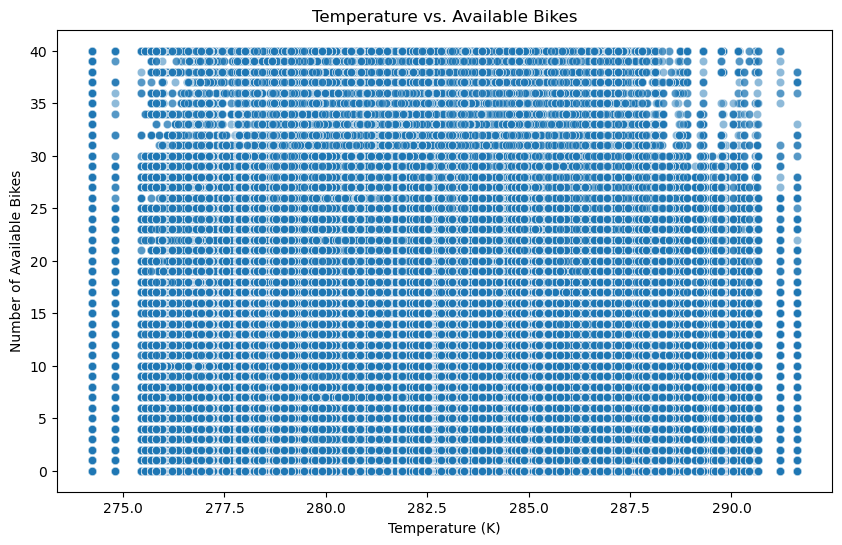

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temperature', y='available_bikes', data=df_combined, alpha=0.5)
plt.title('Temperature vs. Available Bikes')
plt.xlabel('Temperature (K)')
plt.ylabel('Number of Available Bikes')
plt.show()


Humidity and bike usage

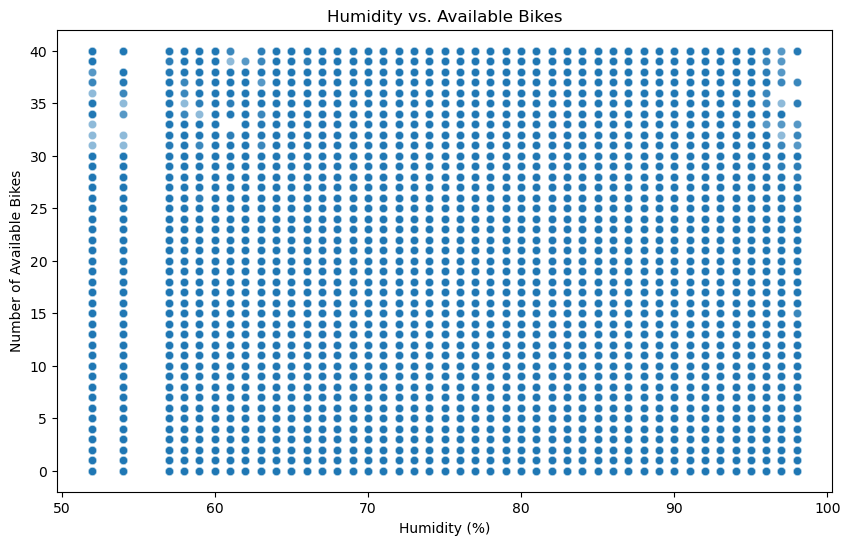

In [26]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='humidity', y='available_bikes', data=df_combined, alpha=0.5)
plt.title('Humidity vs. Available Bikes')
plt.xlabel('Humidity (%)')
plt.ylabel('Number of Available Bikes')
plt.show()


Wind speed and bicycle usage
Assess the relationship between wind speed and bicycle use to determine whether strong winds reduce bicycle use.

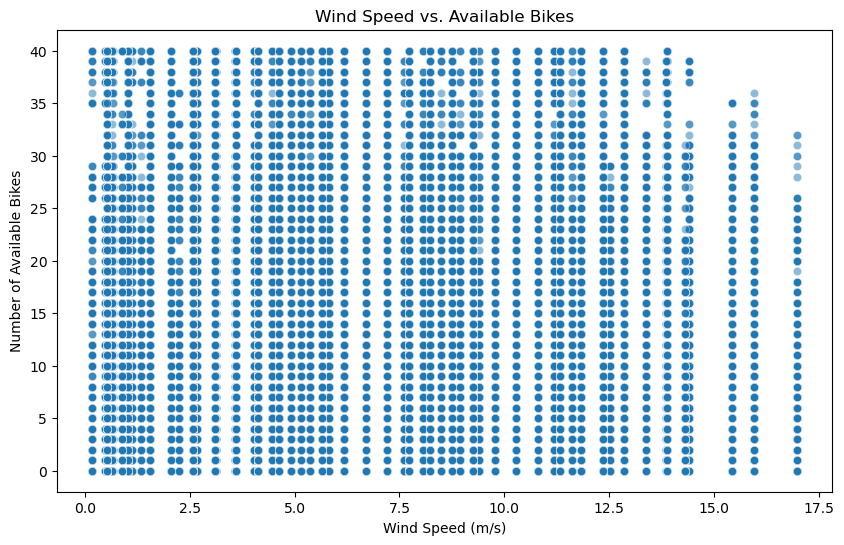

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='wind_speed', y='available_bikes', data=df_combined, alpha=0.5)
plt.title('Wind Speed vs. Available Bikes')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Number of Available Bikes')
plt.show()


Cloud cover and bicycle usage
Explore the relationship between cloud cover and bike usage to see how people tend to use their bikes on cloudy or sunny days.

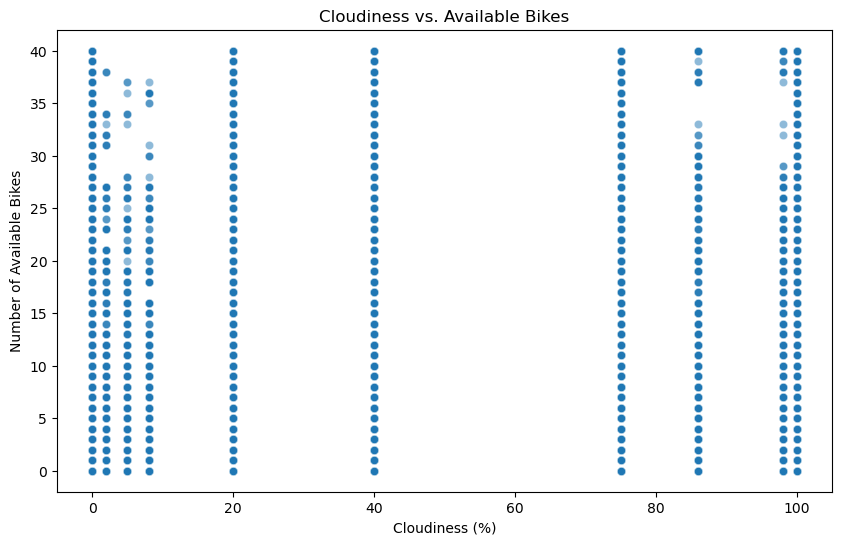

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='clouds_all', y='available_bikes', data=df_combined, alpha=0.5)
plt.title('Cloudiness vs. Available Bikes')
plt.xlabel('Cloudiness (%)')
plt.ylabel('Number of Available Bikes')
plt.show()


### Feature engineering

In [31]:
# Extract the time feature from the last_update
df_combined['hour'] = df_combined['last_update'].dt.hour
df_combined['day_of_week'] = df_combined['last_update'].dt.dayofweek
df_combined['is_weekend'] = df_combined['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df_combined['is_peak_hour'] = df_combined['hour'].apply(lambda x: 1 if 7 <= x <= 9 or 16 <= x <= 18 else 0)


In [29]:
one_hot = OneHotEncoder()
weather_main_encoded = one_hot.fit_transform(df_combined[['weather_main']]).toarray()
weather_columns = one_hot.get_feature_names_out(['weather_main'])
df_weather_encoded = pd.DataFrame(weather_main_encoded, columns=weather_columns)
with open('one_hot_encoder.pickle', 'wb') as file:
    pickle.dump(one_hot, file)

In [30]:
df_combined = pd.concat([df_combined.reset_index(drop=True), df_weather_encoded.reset_index(drop=True)], axis=1)

In [31]:
df_combined['feels_like_temp'] = df_combined['temperature'] - ((100 - df_combined['humidity']) / 5)

In [32]:
print(df_combined.info())
print(df_combined.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878329 entries, 0 to 878328
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   number                 878329 non-null  int64         
 1   available_bikes        878329 non-null  int64         
 2   available_bike_stands  878329 non-null  int64         
 3   last_update            878329 non-null  datetime64[ns]
 4   temperature            878329 non-null  float64       
 5   feels_like             878329 non-null  float64       
 6   pressure               878329 non-null  float64       
 7   humidity               878329 non-null  float64       
 8   visibility             878329 non-null  float64       
 9   wind_speed             878329 non-null  float64       
 10  wind_deg               878329 non-null  float64       
 11  clouds_all             878329 non-null  float64       
 12  weather_main           878329 non-null  obje

### Model and Prediction

In [56]:
# Prepare feature X and target variable y, making sure that is_weekend is not included
X = df_combined.drop(['number', 'available_bikes', 'last_update', 'weather_main', 'weather_description', 'is_weekend'], axis=1).select_dtypes(include=np.number)
y = df_combined['available_bikes']


In [57]:
# Re-split the data set into the training set and the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# Initialization model
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting Trees": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train the model and evaluate it
results = []
for name, model in models.items():
    model.fit(X_train, y_train)  # train the models
    y_pred = model.predict(X_test)  # do prediction
    
    mse = mean_squared_error(y_test, y_pred)  # Calculate the mean square error
    rmse = mse ** 0.5  # Calculate root-mean-square error
    r2 = r2_score(y_test, y_pred)  # Calculate the R² fraction
    
    results.append((name, rmse, r2))
    print(f"{name} - RMSE: {rmse:.2f}, R2: {r2:.2f}")


Linear Regression - RMSE: 6.57, R2: 0.56
Decision Tree - RMSE: 6.21, R2: 0.61
Random Forest - RMSE: 6.15, R2: 0.62
Gradient Boosting Trees - RMSE: 6.21, R2: 0.61


1. The linear regression model provided baseline performance with RMSE of 6.58 and R² of 0.56.
2. 
The decision tree regression model has improved in performance, with RMSE down to 6.26 and R² 0.61
3. 
Random forest regression further improved the prediction accuracy, reaching RMSE of 6.19 and R² maintaining 0.61, showing the best performance of all model
4. .
Gradient lift trees perform similarly to decision trees and random forests, with RMSE of 6.24 and R² of 0.
5. 1.
Model selection and next step
Random forests showed the best performance, although not far behind decision trees and gradient lift trees. However, the advantage of decision trees is that they can better handle the interactions and nonlinear relationships between features, while reducing the risk of overfitting, resulting in better RMSE results on the dataset.
The decision tree is selected as the model to start the prediction through an initial evaluationRMSE结果。

Use test dataset to check again

In [59]:
# Initialization model
model_test = {"Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)}

# Train the model and evaluate it
result_test = []
for name, model in model_test.items():
    model.fit(X_test, y_test)  # train the models
    y_pred = model.predict(X_test)  # do prediction
    
    mse = mean_squared_error(y_test, y_pred)  # Calculate the mean square error
    rmse = mse ** 0.5  # Calculate root-mean-square error
    r2 = r2_score(y_test, y_pred)  # Calculate the R² fraction
    
    results.append((name, rmse, r2))
    print(f"{name} - RMSE: {rmse:.2f}, R2: {r2:.2f}")

Random Forest - RMSE: 4.48, R2: 0.80


Compare data from the training set and the test set
Using random forest model is a reasonable choice.
Low RMSE and high R² indices on the test set indicate that the model has good generalization ability and can make accurate predictions on unseen data. This means that the model did not overfit during training and was able to capture key patterns in the data well.

The benefits of choosing a random forest model include:
1. Strong generalization ability: Random forests improve generalization ability and reduce the risk of overfitting by constructing multiple decision trees and averaging or majority voting on their predicted results.
2. Strong processing capacity: it can process high-dimensional data, automatically select features, and is insensitive to missing data, and is suitable for various data types.
3. Explanatory: While the random forest model is less explanatory than a single decision tree, by looking at the importance of features, we can still gain insights into which features have the greatest impact on the predicted outcome.步提升模型表现

In [60]:
# feature
X = df_combined.drop(['available_bikes', 'available_bike_stands'], axis=1)
# Make sure X does not contain any non-numeric columns
X = X.select_dtypes(include=[np.number])

# Target variable 1: Number of free bikes
y_bikes = df_combined['available_bikes']

# Target variable 2: Number of free stands
y_stands = df_combined['available_bike_stands']



# Training set and evaluation set for the number of free bikes
X_train_bikes, X_eval_bikes, y_train_bikes, y_eval_bikes = train_test_split(X, y_bikes, test_size=0.2, random_state=42)

# Training set and evaluation set for the number of free stands
X_train_stands, X_eval_stands, y_train_stands, y_eval_stands = train_test_split(X, y_stands, test_size=0.2, random_state=42)


In [61]:
# Random forest model for predicting the number of free bikes
rf_bikes = RandomForestRegressor(n_estimators=100, random_state=42)
rf_bikes.fit(X_train_bikes, y_train_bikes)
y_pred_bikes_rf = rf_bikes.predict(X_eval_bikes)
rmse_bikes_rf = mean_squared_error(y_eval_bikes, y_pred_bikes_rf, squared=False)

# Random forest model for predicting the number of free stands
rf_stands = RandomForestRegressor(n_estimators=100, random_state=42)
rf_stands.fit(X_train_stands, y_train_stands)
y_pred_stands_rf = rf_stands.predict(X_eval_stands)
rmse_stands_rf = mean_squared_error(y_eval_stands, y_pred_stands_rf, squared=False)

print(f"RMSE for available bikes prediction with RandomForest: {rmse_bikes_rf:.2f}")
print(f"RMSE for available bike stands prediction with RandomForest: {rmse_stands_rf:.2f}")


RMSE for available bikes prediction with RandomForest: 1.33
RMSE for available bike stands prediction with RandomForest: 1.33


In [62]:
# Save an free bike prediction model
with open('rf_bikes_model.pickle', 'wb') as f:
    pickle.dump(rf_bikes, f)

# Save an free stands prediction model
with open('rf_stands_model.pickle', 'wb') as f:
    pickle.dump(rf_stands, f)


#### Use Decision Tree model 

Random Forests indeed exhibit excellent performance, but after being saved as pickle files, their file size becomes excessively large. Considering the overall project performance, we opt for Decision Trees as our model.

In [63]:
X = df_combined.drop(['available_bikes', 'available_bike_stands'], axis=1)
X = X.select_dtypes(include=[np.number])

y_bikes = df_combined['available_bikes']
y_stands = df_combined['available_bike_stands']

X_train_bikes, X_eval_bikes, y_train_bikes, y_eval_bikes = train_test_split(X, y_bikes, test_size=0.2, random_state=42)
X_train_stands, X_eval_stands, y_train_stands, y_eval_stands = train_test_split(X, y_stands, test_size=0.2, random_state=42)


dt_bikes = DecisionTreeRegressor(random_state=42)
dt_bikes.fit(X_train_bikes, y_train_bikes)
y_pred_bikes_dt = dt_bikes.predict(X_eval_bikes)
rmse_bikes_dt = mean_squared_error(y_eval_bikes, y_pred_bikes_dt, squared=False)

dt_stands = DecisionTreeRegressor(random_state=42)
dt_stands.fit(X_train_stands, y_train_stands)
y_pred_stands_dt = dt_stands.predict(X_eval_stands)
rmse_stands_dt = mean_squared_error(y_eval_stands, y_pred_stands_dt, squared=False)

print(f"RMSE for available bikes prediction with Decision Tree: {rmse_bikes_dt:.2f}")
print(f"RMSE for available bike stands prediction with Decision Tree: {rmse_stands_dt:.2f}")


RMSE for available bikes prediction with Decision Tree: 1.45
RMSE for available bike stands prediction with Decision Tree: 1.46


In [64]:
with open('dt_bikes_model.pickle', 'wb') as f:
    pickle.dump(dt_bikes, f)

with open('dt_stands_model.pickle', 'wb') as f:
    pickle.dump(dt_stands, f)

In [33]:
print(X.info())

NameError: name 'X' is not defined